# Development for ER3BP Differential Corrector

Yuri Shimane

In [58]:
using LinearAlgebra
using DifferentialEquations
using Plots
using Printf
using ProgressMeter

using FiniteDiff
using ForwardDiff

In [59]:
gr()

Plots.GRBackend()

In [146]:
include("../R3BP/src/R3BP.jl")

LoadError: LoadError: UndefVarError: ODECompositeSolution not defined
in expression starting at C:\Users\yshimane3\Documents\codes\dev-julia\julia-R3BP\R3BP\src\librationpointorbit\manifold.jl:8
in expression starting at C:\Users\yshimane3\Documents\codes\dev-julia\julia-R3BP\R3BP\src\R3BP.jl:1

In [61]:
reltol = 1e-15
abstol = 1e-15
maxiter = 15

15

In [63]:
ecc = 0.01 # to up 0.0549
t0 = 0.0

0.0

In [70]:
function ssdc_halo(p, x0, period0, system="cr3bp", tolnewton=1e-12, maxiter=15, reltol=1e-13, abstol=1e-13)
    # initalize problem
    x0iter = copy(x0)
    period = copy(period0)
    method = Tsit5()
    
    # newton iterate
    for i = 1:maxiter
        x0_stm = vcat(x0iter, reshape(I(6), (36,)))[:] 
        #hcat(x0iter, [1 0 0 0 0 0  0 1 0 0 0 0  0 0 1 0 0 0  0 0 0 1 0 0  0 0 0 0 1 0  0 0 0 0 0 1])[:];
        if cmp(system, "cr3bp")==0
            prob = ODEProblem(R3BP.rhs_cr3bp_svstm!, x0_stm, period/2, p,
                method=method, reltol=reltol, abstol=abstol
            );
        else
            prob = ODEProblem(R3BP.rhs_er3bp_svstm!, x0_stm, period/2, p,
                method=method, reltol=reltol, abstol=abstol
            );
        end
        # solve ODE problem
        sol = solve(prob, reltol=reltol, abstol=abstol);
        # construct stm
        stm = reshape(sol.u[end][7:end], (6,6))';
        
        # get state derivative at the end
        statef = sol.u[end]

        # Newton solver, fix Z
        #      x,         z,         vy
        xi = [ x0iter[1], x0iter[3], x0iter[5] ]
        # correction on: y, vx, vz
        df = [ stm[2,1] stm[2,3] stm[2,5];     # dy/dx, dy/dz, dy/dvy
               stm[4,1] stm[4,3] stm[4,5];     # dvx/dx, dvx/dz, dvx/dvy
               stm[6,1] stm[6,3] stm[6,5] ];   # dvz/dx, dvz/dz, dvz/dvy

        # correct state
        ferr = [ statef[2], statef[4], statef[6] ]
        @printf("Iter %i, |ferr| = %1.6e\n", i, norm(ferr))
        if norm(ferr) < tolnewton
            @printf("Newton convered after %i iterations, ferr = %1.6e\n", i, norm(ferr))
            break
        end
        xii = xi - inv(df)*ferr

        # store next solution, fix Z
        x0iter[1] = xii[1];   # overwrite x
        x0iter[3] = xii[2];   # overwrite z
        x0iter[5] = xii[3];   # overwrite vy
    end
    
    return x0iter, period
end

ssdc_halo (generic function with 6 methods)

We start with an a priori obtained CR3BP periodic solution - in this case, a M2N1 halo (period of π). 

In [71]:
# define parameters - using initial condition of a M2N1-halo in Earth-Moon ER3BP system
mu = 0.01215058426994;
X0 = [1.143749298238092, 0.0, -0.157507529813055, 0.0, -0.221868721418453, 0.0];
T = π;

In [72]:
# we re-run the single-shooting differential correction, just in case
X0corr, Tcorr = ssdc_halo((mu), X0, T)

Iter 1, |ferr| = 2.541335e-07
Iter 2, |ferr| = 1.403629e-13
Newton convered after 2 iterations, ferr = 1.403629e-13


([1.1437492946706131, 0.0, -0.1575075219394079, 0.0, -0.22186871318299356, 0.0], π)

Let's propagate this solution in *CR3BP* and plot, to make sure it is indeed **periodic**.

Let's also propagate this in *ER3BP* and plot - now, we expect it to **not be periodic**. 

In [73]:
# propagation in CR3BP
tspan = (0.0, T)
p = (mu)
prob = ODEProblem(R3BP.rhs_cr3bp_sv!, X0corr, tspan, p, method=Tsit5(), reltol=reltol, abstol=abstol)
sol = DifferentialEquations.solve(prob);

In [74]:
# propagation in ER3BP
tspan = (0.0, T)
pe = (mu,ecc,t0)
probe = ODEProblem(R3BP.rhs_er3bp_sv!, X0corr, tspan, pe, method=Tsit5(), reltol=reltol, abstol=abstol)
sole = DifferentialEquations.solve(probe);

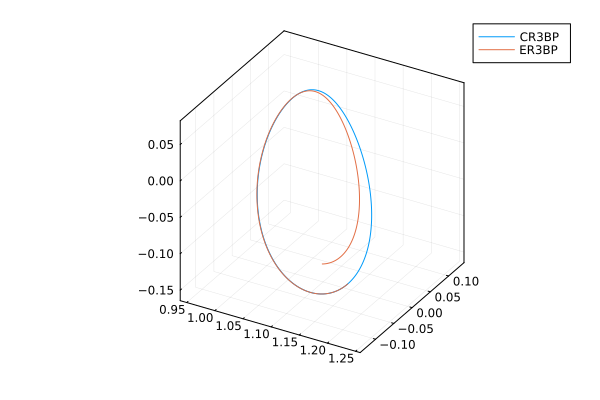

In [75]:
p = plot(frame_style=:box)
plot!(p, sol, vars=(1,2,3), label="CR3BP")
plot!(p, sole, vars=(1,2,3), label="ER3BP")
p

#### Check monodormy for CR3BP case

The monodromy matrix must have certain properties which we can check. 

In [15]:
# analytical propagation
tspan = (0.0, T)
p = (mu)
prob = ODEProblem(
    R3BP.rhs_cr3bp_svstm!, vcat(X0corr, reshape(I(6), (36,)))[:], tspan, p, method=Tsit5(), reltol=reltol, abstol=abstol
)
solcr3bpstm = DifferentialEquations.solve(prob);
monodromy_cr3bp_analytical = reshape(solcr3bpstm.u[end][7:end], (6,6))'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
  75.0475  -50.1464   -47.4147    44.7942    7.40534    -9.01764
 -11.55      8.46924    8.58197   -7.40534  -1.18717     0.825656
 -13.9753    9.60681    9.78107   -9.01764  -0.825656    1.41974
 100.458   -66.807    -63.0455    60.2368    9.17569   -12.324
 -66.3495   44.7574    42.6924   -39.4421   -6.34145     8.42847
 -80.2094   52.1369    50.0723   -47.4147   -8.58197     9.78107

In [16]:
function analyze_monodromy(monodromy)
    lmbs = eigvals(monodromy)
    for lmb in lmbs
        @printf("lmb: % e + j% e, norm = %f\n",real(lmb), imag(lmb), norm(lmb))
    end
    return
end

analyze_monodromy (generic function with 1 method)

In [17]:
analyze_monodromy(monodromy_cr3bp_analytical)

lmb: -2.242282e-01 + j-9.745367e-01, norm = 1.000000
lmb: -2.242282e-01 + j 9.745367e-01, norm = 1.000000
lmb:  6.434337e-03 + j 0.000000e+00, norm = 0.006434
lmb:  1.000000e+00 + j-1.752841e-06, norm = 1.000000
lmb:  1.000000e+00 + j 1.752841e-06, norm = 1.000000
lmb:  1.554162e+02 + j 0.000000e+00, norm = 155.416164


In [18]:
# wrapper function for propagating in CR3BP
function propagate_cr3bp(x0, tf, p)
    prob = ODEProblem(R3BP.rhs_cr3bp_sv!, x0, (0, tf), p, method=Tsit5(), reltol=reltol, abstol=abstol)
    sol = DifferentialEquations.solve(prob);
    return sol.u[end]
end

propagate_cr3bp (generic function with 1 method)

We now develop a way to compute the state-transition matrix by using Automatic Differentiation (AD). The procedure is the same as with MCX; we let the 6 states to be the variables along which the dual number (or multicomplex direction) is assigned, then compute the Jacobian. 

In [19]:
monodromy_cr3bp_ad = ForwardDiff.jacobian(X0corr -> propagate_cr3bp(X0corr, T, (mu)), X0corr)

6×6 Matrix{Float64}:
  75.0475  -50.1464   -47.4147    44.7942    7.40534    -9.01764
 -11.55      8.46924    8.58197   -7.40534  -1.18717     0.825656
 -13.9753    9.60681    9.78107   -9.01764  -0.825656    1.41974
 100.458   -66.807    -63.0455    60.2368    9.17569   -12.324
 -66.3495   44.7574    42.6924   -39.4421   -6.34145     8.42847
 -80.2094   52.1369    50.0723   -47.4147   -8.58197     9.78107

In the autonomous case, the analyitical STM and the AD based STM are the same within (almost) numerical accuracy (keeping in mind the error tolerance of the integrator as well). 

In [20]:
monodromy_cr3bp_analytical - monodromy_cr3bp_ad

6×6 Matrix{Float64}:
  1.79057e-12  -8.17124e-13  -6.82121e-13  …   2.90434e-13  -2.22045e-13
 -1.11555e-12   6.83897e-13   6.18172e-13     -1.32339e-13   1.23457e-13
  1.18483e-12  -8.36664e-13  -8.18901e-13      1.08136e-13  -1.55875e-13
  1.64846e-12  -5.40012e-13  -4.40536e-13      3.49942e-13  -2.23821e-13
 -2.58638e-12   1.4424e-12    1.34293e-12     -3.3662e-13    2.96652e-13
  2.13163e-12  -1.81899e-12  -1.76215e-12  …   9.76996e-14  -2.62901e-13

In [21]:
analyze_monodromy(monodromy_cr3bp_ad)

lmb: -2.242282e-01 + j-9.745367e-01, norm = 1.000000
lmb: -2.242282e-01 + j 9.745367e-01, norm = 1.000000
lmb:  6.434337e-03 + j 0.000000e+00, norm = 0.006434
lmb:  1.000000e+00 + j-1.765760e-06, norm = 1.000000
lmb:  1.000000e+00 + j 1.765760e-06, norm = 1.000000
lmb:  1.554162e+02 + j 0.000000e+00, norm = 155.416164


In [22]:
analyze_monodromy(monodromy_cr3bp_analytical)

lmb: -2.242282e-01 + j-9.745367e-01, norm = 1.000000
lmb: -2.242282e-01 + j 9.745367e-01, norm = 1.000000
lmb:  6.434337e-03 + j 0.000000e+00, norm = 0.006434
lmb:  1.000000e+00 + j-1.752841e-06, norm = 1.000000
lmb:  1.000000e+00 + j 1.752841e-06, norm = 1.000000
lmb:  1.554162e+02 + j 0.000000e+00, norm = 155.416164


### Experiment with ER3BP

In [23]:
# define the "extended state" ([r,v] & STM)
X0stm = vcat(X0corr, reshape(I(6), (36,)))[:];

In [24]:
# test propagation of ER3BP with the (analytical) STM
tspan = (0.0, T)
pe = (mu,ecc,t0)
probes = ODEProblem(R3BP.rhs_er3bp_svstm!, X0stm, tspan, pe, method=Tsit5(), reltol=reltol, abstol=abstol)
soles = DifferentialEquations.solve(probes);

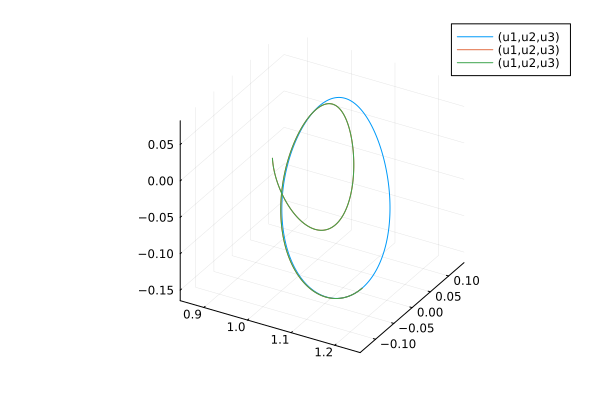

In [25]:
p = plot()
plot!(p, sol, vars=(1,2,3))
plot!(p, sole, vars=(1,2,3))
plot!(p, soles, vars=(1,2,3))
p

In [26]:
# analytical STM
stm_er3bp_analytical = reshape(soles.u[end][7:end], (6,6))'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
   14.5765   -10.7977   -10.2084      9.20829   1.44491     -1.58375
    6.87918   -4.8045    -4.72335     4.53667   0.00865422  -1.05791
  -32.7491    22.7078    23.2065    -21.0332   -1.31348      4.86758
 -204.8      139.575    144.075    -131.032    -7.20104     31.8528
   -5.02853    3.35896   -1.63012    -1.45292   0.0519155    2.18299
   71.7665   -55.3927   -51.7183     45.5462    9.32065     -5.82093

In [33]:
# wrapper function for propagating
function propagate_er3bp(x0, tf, p)
    prob = ODEProblem(R3BP.rhs_er3bp_sv!, x0, (0, tf), p, method=Tsit5(), reltol=reltol, abstol=abstol)
    sol = DifferentialEquations.solve(prob);
    return sol.u[end]
end

propagate_er3bp (generic function with 1 method)

In [34]:
prob = ODEProblem(R3BP.rhs_er3bp_sv!, X0corr, (0, T), p);

In [40]:
# wrapper function for propagating and getting the final state (faster by using the remake function)
function get_statef(prob, x0, tf, p)
    _prob = remake(prob, u0=x0, p=p)
    sol = solve(_prob, saveat=tf)
    return sol.u[end]
end

get_statef (generic function with 1 method)

In [41]:
# AD based STM for the ER3BP
stm_ad = ForwardDiff.jacobian(X0corr -> get_statef(prob, X0corr, T, pe), X0corr)

6×6 Matrix{Float64}:
   14.454    -10.7525   -10.1455      9.16107   1.42091    -1.52692
    6.98568   -4.86734   -4.779       4.59632   0.0332254  -1.05981
  -33.0246    22.8732    23.3248    -21.1902   -1.39875     4.82989
 -207.247    140.996    145.218    -132.384    -7.88399    31.743
   -5.01602    3.33589   -1.49321    -1.44005   0.0838      2.25159
   70.6545   -54.9651   -51.1632     45.1008    9.05391    -5.42539

Now for the non-autonomous case, we notice that the STM is different!

In [42]:
stm_er3bp_analytical - stm_ad

6×6 Matrix{Float64}:
  0.122523  -0.0452824  -0.062916    0.0472192   0.0239948  -0.056835
 -0.106496   0.0628339   0.0556411  -0.0596478  -0.0245712   0.00189674
  0.275467  -0.165353   -0.118308    0.156934    0.0852686   0.0376878
  2.44741   -1.42032    -1.14302     1.35146     0.682952    0.109798
 -0.012514   0.0230777  -0.136911   -0.0128658  -0.0318845  -0.0685942
  1.11197   -0.427636   -0.555165    0.445433    0.266743   -0.395542

In [43]:
propagate_er3bp(X0corr, T, pe)

6-element Vector{Float64}:
  0.9406907026125373
 -0.002985414719016306
 -0.012975699859014058
  0.0826936345322282
 -0.15815087153206286
  0.6133094969280284

In [44]:
# for sanity checking; this is with forward difference
stm_fd = FiniteDiff.finite_difference_jacobian(X0corr -> propagate_er3bp(X0corr, T, pe), X0corr)

6×6 Matrix{Float64}:
   14.4407   -10.7443   -10.1372      9.15266   1.42045    -1.5247
    6.99218   -4.87099   -4.7826      4.60031   0.0340871  -1.06041
  -33.0376    22.8796    23.3306    -21.1977   -1.40102     4.83091
 -207.343    141.035    145.258    -132.44     -7.89536    31.7544
   -5.04777    3.35638   -1.47304    -1.46068   0.082892    2.25618
   70.7631   -55.0551   -51.2553     45.1726    9.05874    -5.43972

In [45]:
stm_fd - stm_ad

6×6 Matrix{Float64}:
 -0.0133027    0.00818832   0.00821952  …  -0.000461115   0.00222193
  0.00649904  -0.00365302  -0.00360247      0.000861759  -0.000596143
 -0.0130808    0.00638797   0.0058227      -0.00226456    0.0010234
 -0.095831     0.0393643    0.0399584      -0.0113705     0.0113356
 -0.0317571    0.020493     0.0201727      -0.000907953   0.00459355
  0.108588    -0.0900163   -0.0921374   …   0.00482975   -0.0143293

In [46]:
stm_er3bp_analytical - stm_ad

6×6 Matrix{Float64}:
  0.122523  -0.0452824  -0.062916    0.0472192   0.0239948  -0.056835
 -0.106496   0.0628339   0.0556411  -0.0596478  -0.0245712   0.00189674
  0.275467  -0.165353   -0.118308    0.156934    0.0852686   0.0376878
  2.44741   -1.42032    -1.14302     1.35146     0.682952    0.109798
 -0.012514   0.0230777  -0.136911   -0.0128658  -0.0318845  -0.0685942
  1.11197   -0.427636   -0.555165    0.445433    0.266743   -0.395542

In [47]:
T, pe

(π, (0.01215058426994, 0.0549, 0.0))

Now let's try converging to periodic orbit using single shooting. 
    
We first by doing so using anlaytical STM. 

In [76]:
maxiter = 15
# it seems convergence is better for 2 pi
X0corr_er3bp, Tcorr_er3bp = ssdc_halo(pe, X0corr, 2T, "er3bp", 1e-12, maxiter, reltol, abstol)

Iter 1, |ferr| = 9.214414e-02
Iter 2, |ferr| = 1.109654e-02
Iter 3, |ferr| = 4.136338e-03
Iter 4, |ferr| = 2.541538e-05
Iter 5, |ferr| = 6.038970e-08
Iter 6, |ferr| = 5.115299e-10
Iter 7, |ferr| = 3.640741e-13
Newton convered after 7 iterations, ferr = 3.640741e-13


([1.1439904705889214, 0.0, -0.15814376974091723, 0.0, -0.22167853554171618, 0.0], 6.283185307179586)

In [77]:
T, ecc

(π, 0.01)

In [78]:
tspan = (0.0, 2π)
pe = (mu, ecc, t0)
probcorr_e = ODEProblem(R3BP.rhs_er3bp_sv!, X0corr_er3bp, tspan, pe, method=Tsit5(), reltol=reltol, abstol=abstol) 
solcorr_e = DifferentialEquations.solve(probcorr_e);
solcorr_e.u[end]

6-element Vector{Float64}:
  1.1439904706016448
 -1.8476631235909883e-12
 -0.1581437697430669
  1.6781905624690654e-11
 -0.22167853555342112
 -1.3157299102077404e-11

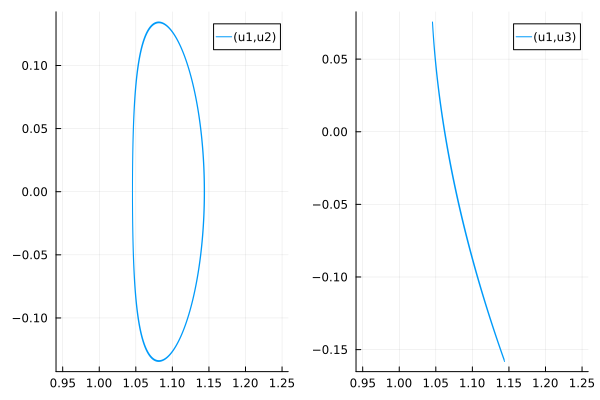

In [79]:
p1 = plot(solcorr_e, vars=(1,2))
p2 = plot(solcorr_e, vars=(1,3))
plot(p1,p2)

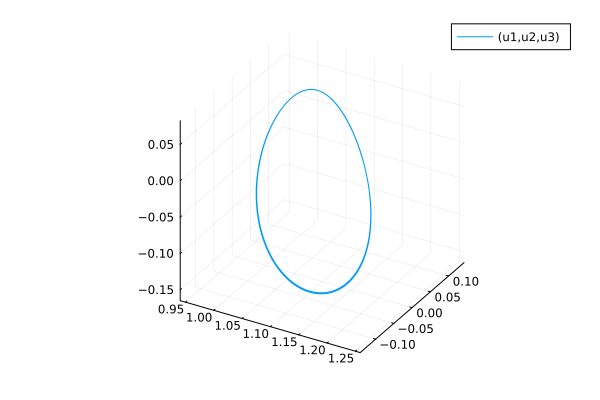

In [80]:
p = plot()
# plot!(p, sol, vars=(1,2,3))
# plot!(p, sole, vars=(1,2,3))
plot!(p, solcorr_e, vars=(1,2,3))
p

In [81]:
X0corr, T

([1.1437492946706131, 0.0, -0.1575075219394079, 0.0, -0.22186871318299356, 0.0], π)

In [82]:
pe = (mu, 0.02, t0)

(0.01215058426994, 0.02, 0.0)

In [83]:
# correction with function implemented inside R3BP
rese_analytical = R3BP.ssdc_periodic_xzplane(pe, X0corr, 2T, system="er3bp");  # stm_option="analytical")
rese_ad = R3BP.ssdc_periodic_xzplane(pe, X0corr, 2T, system="er3bp", stm_option="ad");

In [84]:
rese_analytical.x0

6-element Vector{Float64}:
  1.144242199314076
  0.0
 -0.15876928906044258
  0.0
 -0.22149521692844013
  0.0

In [85]:
rese_ad.x0

6-element Vector{Float64}:
  1.1442421993140777
  0.0
 -0.15876928906043966
  0.0
 -0.2214952169284396
  0.0

### Continuation until eccentricity of interest

In [88]:
#probfun = ODEProblem(R3BP.rhs_er3bp_sv!, rese.x0, (0.0, rese.period), pe)
pe = (mu, ecc, t0)
probfun = ODEProblem(R3BP.rhs_er3bp_sv!, rese_analytical.x0, (0.0, 2π), pe, method=Tsit5(), reltol=reltol, abstol=abstol)
solfun = DifferentialEquations.solve(probfun);

In [89]:
T

π = 3.1415926535897...

In [90]:
tolDC = 1.e-12

1.0e-12

In [123]:
ecc_obj = 0.0549 #5  # 0.0549   # final eccentricty to get to
ecc_step = 0.02
ecc_current = 0.0
X0init = X0corr
Tinit = π
ecc_list = []
res_list = []
sol_list = []
iter = 0
stm_option = "analytical"
method = Tsit5()

prob_base = ODEProblem(R3BP.rhs_er3bp_sv!, X0init, 1.0, pe,
    method=method, reltol=reltol, abstol=abstol
);

while ecc_current < ecc_obj
    iter += 1
    # update on eccentricity
    decc = min(ecc_step, ecc_obj - ecc_current)
    ecc_current += decc
    push!(ecc_list, ecc_current)
    println("iter $iter, e = $ecc_current")
    
    # solve next iteration
    @show pe = (mu, ecc_current, t0)
    res = R3BP.ssdc_periodic_xzplane(pe, X0init, 2π, system="er3bp", tolDC=tolDC, maxiter=40, stm_option=stm_option)
    X0init = copy(res.x0)
    push!(res_list, res)
    if res.flag == 1
        _prob = remake(prob_base; tspan=(0.0, res.period), u0=X0init, p=pe)
        sol = solve(_prob)
        push!(sol_list, sol)
    end
end

iter 1, e = 0.02
pe = (mu, ecc_current, t0) = (0.01215058426994, 0.02, 0.0)
iter 2, e = 0.04
pe = (mu, ecc_current, t0) = (0.01215058426994, 0.04, 0.0)
iter 3, e = 0.0549
pe = (mu, ecc_current, t0) = (0.01215058426994, 0.0549, 0.0)


In [145]:
t0

0.0

In [153]:
X0stm = vcat(res_list[end].x0, reshape(I(6), (6^2,)))[:]
tspan = [0, res_list[end].period]
pe = [mu, ecc_current, t0]

probes = ODEProblem(R3BP.rhs_er3bp_svstm!, X0stm, tspan, pe, method=Tsit5(), reltol=reltol, abstol=abstol)
soles = DifferentialEquations.solve(probes);
monodromy = transpose(reshape(soles.u[end][7:end], (6,6)))
analyze_monodromy(monodromy)

lmb: -9.035937e-01 + j-4.283906e-01, norm = 1.000000
lmb: -9.035937e-01 + j 4.283906e-01, norm = 1.000000
lmb:  4.073275e-05 + j 0.000000e+00, norm = 0.000041
lmb:  9.268571e-01 + j 0.000000e+00, norm = 0.926857
lmb:  1.078915e+00 + j 0.000000e+00, norm = 1.078915
lmb:  2.455027e+04 + j 0.000000e+00, norm = 24550.269746


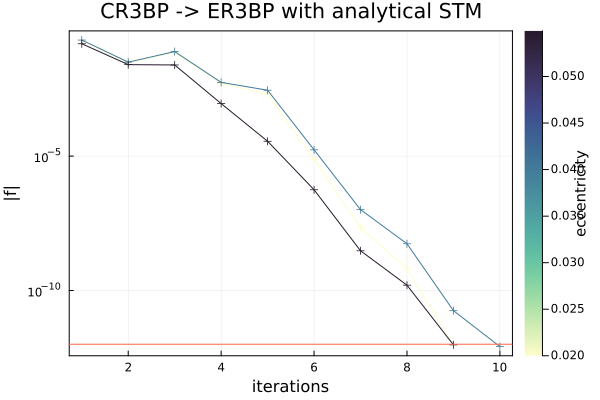

In [99]:
pfa = plot(title="CR3BP -> ER3BP with analytical STM", grid=:true, legend=false, frame_style=:box,
        xlabel="iterations", ylabel="|f|", colorbar_title="eccentricity")
for i = 1:length(res_list)
    nf = length(res_list[i].fiters)
    e_of_plot = ecc_list[i]
    plot!(pfa, LinRange(1, nf, nf), res_list[i].fiters, yaxis=:log, label="e = $e_of_plot", 
        marker=:cross, zcolor=ecc_list[i], line_z=ecc_list[i], c=cgrad(:deep), colorbar=true)
end
# bar on tolerance
hline!(pfa, [tolDC], c=:tomato)
pfa

Now let:s try with AD

In [100]:
#ecc_obj = 0.02 #5  # 0.0549   # final eccentricty to get to
ecc_step = 0.02
ecc_current = 0.0
X0init = X0corr
Tinit = π
ecc_list_ad = []
res_list_ad = []
sol_list_ad = []
iter = 0
stm_option = "ad"

prob_base = ODEProblem(R3BP.rhs_er3bp_sv!, X0init, 1.0, pe,
    method=method, reltol=reltol, abstol=abstol
);

while ecc_current < ecc_obj
    iter += 1
    # update on eccentricity
    decc = min(ecc_step, ecc_obj - ecc_current)
    ecc_current += decc
    push!(ecc_list_ad, ecc_current)
    println("iter $iter, e = $ecc_current")
    
    # solve next iteration
    pe = (mu, ecc_current, t0)
    res = R3BP.ssdc_periodic_xzplane(pe, X0init, 2π, system="er3bp", tolDC=tolDC, maxiter=20, stm_option=stm_option)
    X0init = copy(res.x0)
    push!(res_list_ad, res)
    if res.flag == 1
        _prob = remake(prob_base; tspan=(0.0, res.period), u0=X0init, p=pe)
        sol = solve(_prob)
        push!(sol_list_ad, sol)
    end
end

iter 1, e = 0.02
iter 2, e = 0.04
iter 3, e = 0.0549


In [101]:
res_list_ad[1].flag

1

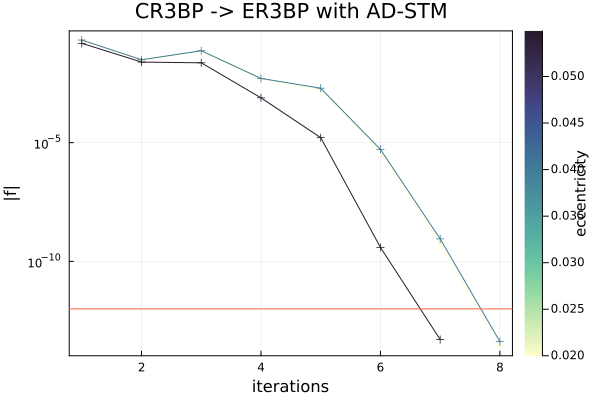

In [102]:
pfn = plot(title="CR3BP -> ER3BP with AD-STM", grid=:true, legend=false, frame_style=:box,
        xlabel="iterations", ylabel="|f|", colorbar_title="eccentricity")
for i = 1:length(res_list_ad)
    nf = length(res_list_ad[i].fiters)
    e_of_plot = ecc_list[i]
    plot!(pfn, LinRange(1, nf, nf), res_list_ad[i].fiters, yaxis=:log, label="e = $e_of_plot", 
        marker=:cross, zcolor=ecc_list[i], line_z=ecc_list[i], c=cgrad(:deep),#palette([:purple, :green], length(res_list_ad)), 
        colorbar=true)
end
# bar on tolerance
hline!(pfn, [tolDC], c=:tomato)
pfn

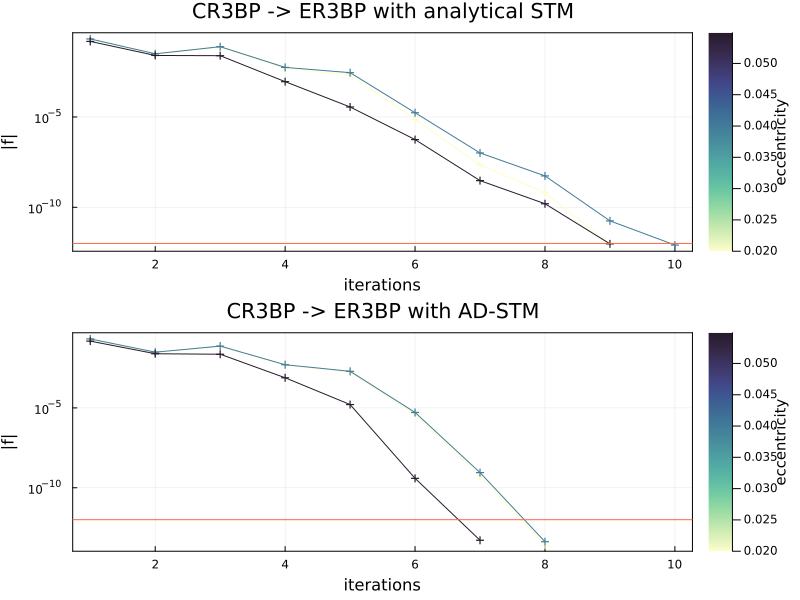

In [104]:
pcomb = plot(pfa,pfn,layout=(2,1),size=(800,600), link=:x)
pcomb

In [106]:
#savefig(pcomb, "plots/er3bp_transition.pdf")

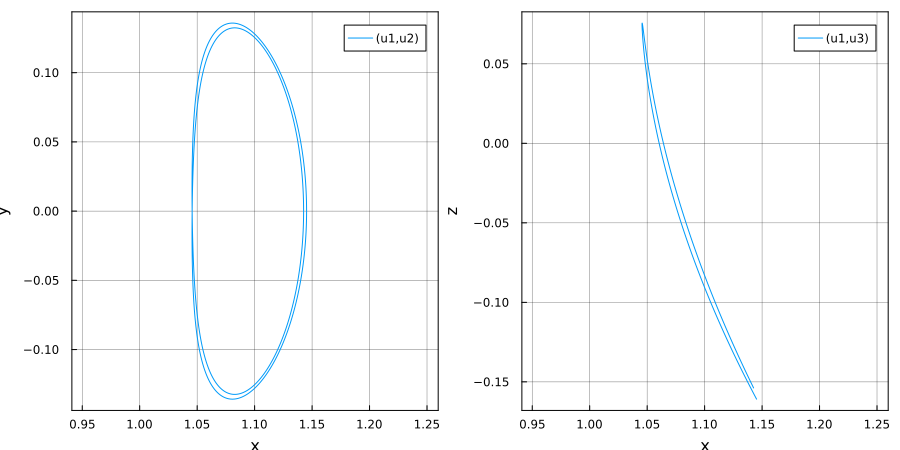

In [136]:
p1 = plot(sol_list[end], vars=(1,2), xlabel="x", ylabel="y")
p2 = plot(sol_list_ad[end], vars=(1,3), xlabel="x", ylabel="z")
plot(p1,p2; layout=(1,2), size=(900,450), frame_style=:box, gridalpha=0.5, fontsize=16)

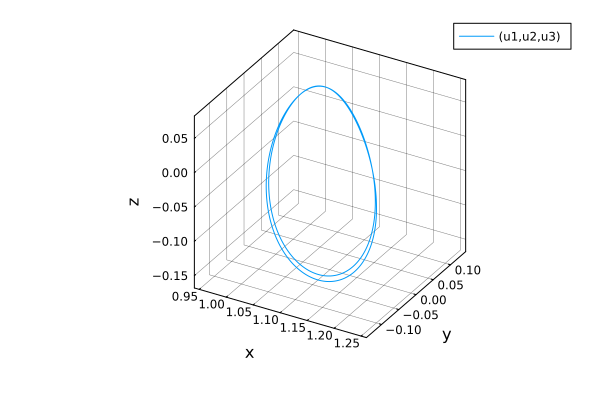

In [130]:
p = plot()
# plot!(p, sol, vars=(1,2,3))
# plot!(p, sole, vars=(1,2,3))
plot!(p, sol_list_ad[end], vars=(1,2,3), xlabel="x", ylabel="y", zlabel="z", frame_style=:box, gridalpha=0.5)
p

In [111]:
lps = R3BP.lagrangePoints(mu)

5×6 Matrix{Float64}:
  0.836915   0.0       0.0  0.0  0.0  0.0
  1.15568    0.0       0.0  0.0  0.0  0.0
 -1.00506    0.0       0.0  0.0  0.0  0.0
  0.487849   0.866025  0.0  0.0  0.0  0.0
  0.487849  -0.866025  0.0  0.0  0.0  0.0

In [112]:
length(cgrad(:deep))

256

In [113]:
function interp_cgrad(val, minval, maxval, cs = cgrad(:deep))
    cval = convert(Int64, round(255*(val-minval)/(maxval-minval)))+1
    return cs[cval]
end

interp_cgrad (generic function with 2 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


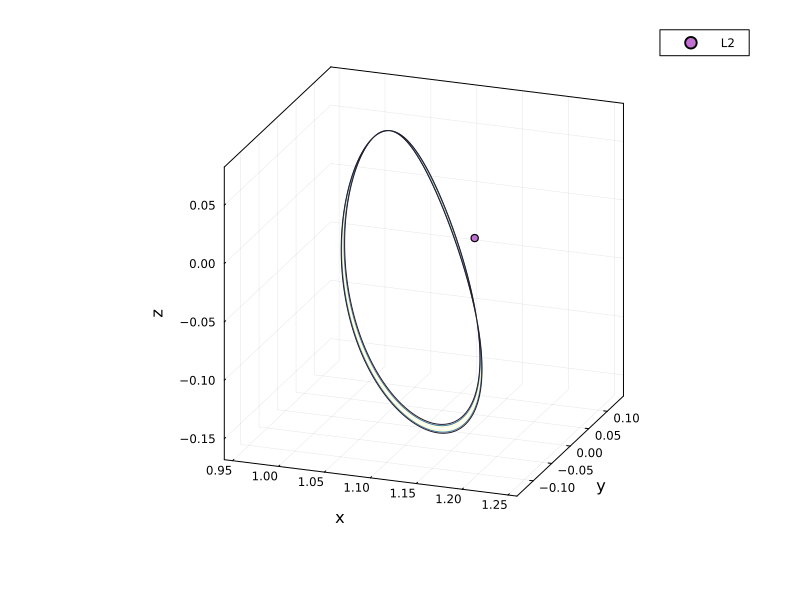

In [115]:
ptraj_ad = plot(legend=true, frame_style=:box, xlabel="x", ylabel="y", zlabel="z", camera=(20,20), size=(800,600),
         colorbar_title="eccentricity", colorbar=true)
@showprogress for (i,sol) in enumerate(sol_list_ad)
    e_iter = ecc_list_ad[i]
    plot!(ptraj_ad, sol, vars=(1,2,3), label=false, 
        c=interp_cgrad(e_iter, minimum(ecc_list), maximum(ecc_list)), colorbar=true)
end
scatter!(ptraj_ad, [lps[2,1]], [lps[2,2]], [lps[2,3]], marker=:circle, label="L2")
ptraj_ad

In [116]:
#savefig(ptraj_ad, "plots/ptraj_ad.pdf")

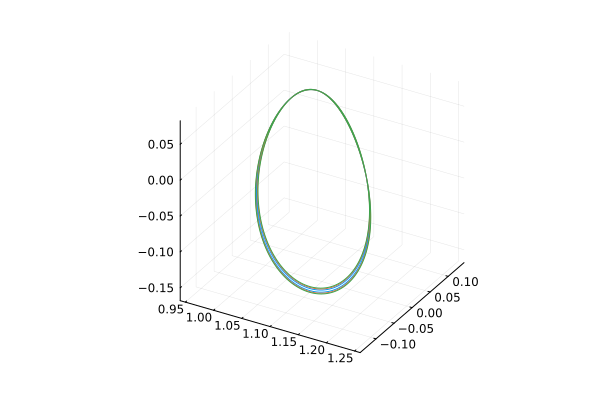

In [117]:
p = plot(legend=false)
@showprogress for sol in sol_list
    plot!(p, sol, vars=(1,2,3))
end
p

In [157]:
# p = plot()
# for i = 1:length(res_list_ad)
#     plot!(p, res_list_ad[i].sol, vars=(1,2,3))
# end
# p